In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
from sqlalchemy import create_engine

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
import os
os.listdir('.')

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 'app.py',
 'climate_starter.ipynb',
 'README.md',
 'Resources']

In [5]:
# reflect an existing database into a new model
from sqlalchemy.ext.automap import automap_base
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
mapped_classes = Base.classes.keys()
print(mapped_classes)

['station', 'measurement']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import sessionmaker

# Create a session factory
Session = sessionmaker(bind=engine)

# Create a new session instance
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
from sqlalchemy import desc

# Query the most recent date
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

print(f"Most Recent Date: {most_recent_date[0]}")

Most Recent Date: 2017-08-23


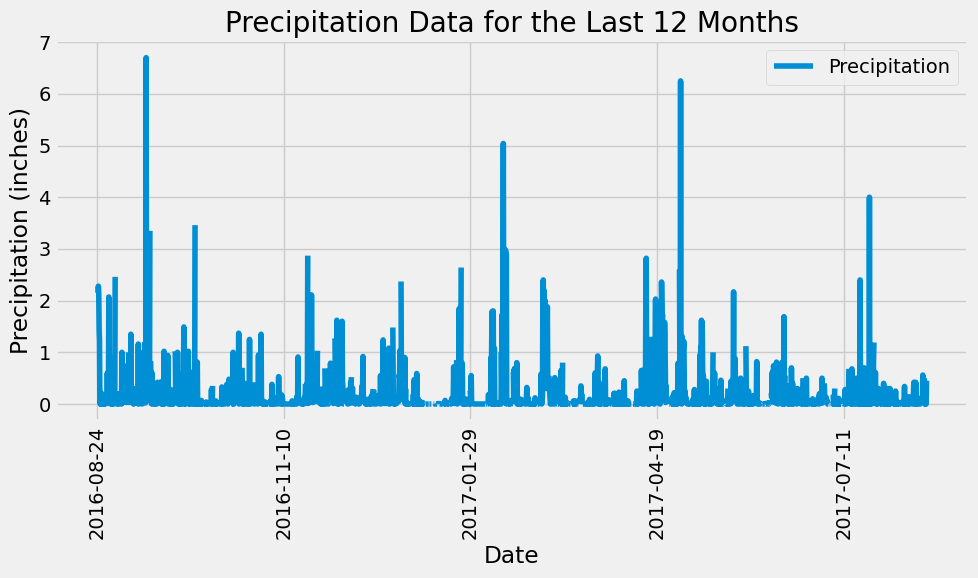

In [10]:
from sqlalchemy import func
from datetime import datetime, timedelta
import pandas as pd

# Step 1: Calculate the date one year from the last date in the dataset
most_recent_date_str = most_recent_date[0]  # Extracting the date from the tuple
most_recent_date_obj = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
date_one_year_ago = most_recent_date_obj - timedelta(days=365)

# Step 2: Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_one_year_ago).\
    all()

# Step 3: Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Step 4: Sort the dataframe by date
df = df.sort_index()

# Step 5: Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, figsize=(10, 6))
plt.title("Precipitation Data for the Last 12 Months")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df.describe()

# Embellish the summary statistics using Pandas' styling capabilities
styled_summary = summary_statistics.style.format("{:.2f}").set_caption("Precipitation Data Summary Statistics")

styled_summary = styled_summary.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-weight', 'bold'),
        ('font-size', '16px'),
        ('text-align', 'center')
    ]
}])

# Display the styled summary
display(styled_summary)


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

# Query to calculate the total number of stations
total_stations = session.query(Station.station).distinct().count()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the ID of the most active station
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Display the results
low_temp, high_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {low_temp}")
print(f"Highest Temperature: {high_temp}")
print(f"Average Temperature: {round(avg_temp, 2)}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


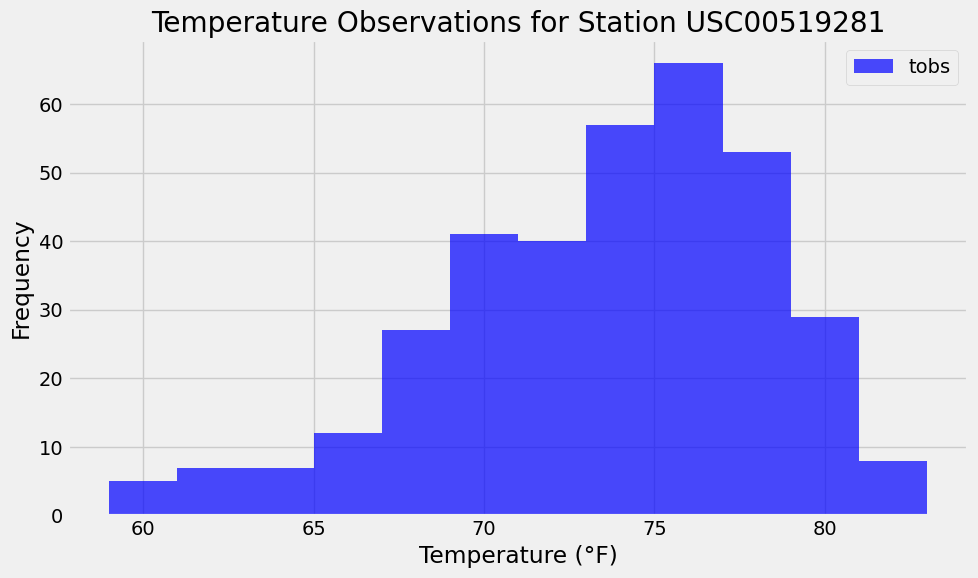

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 12 months from the most recent data point
end_date = session.query(func.max(Measurement.date)).scalar()
start_date = (dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= start_date)
    .all()
)

# Convert the results to a Pandas DataFrame
df_temp = pd.DataFrame(temperature_data, columns=["tobs"])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_temp["tobs"], bins=12, color='blue', alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()